In [4]:
"""
use time to cut sequences
command 
python main_time.py --data_folder ../Data/xing/ --train_data train_item.pickle --valid_data test_item.pickle --test_data test_item.pickle --data_name xing --embedding_dim 300 --hidden_size 300 --lr 0.005
"""
import argparse
import torch
# import lib
import numpy as np
import os
import datetime
from loss import *
from network import *
from optimizer import *
from trainer import *
from torch.utils import data
import pickle
import sys
from dataset_time import *
# from data_time import *
from logger import *
import collections

import sys
sys.path.insert(0, '../PyTorch_GBW_LM')
sys.path.insert(0, '../PyTorch_GBW_LM/log_uniform')

from sampledSoftmax import *

In [5]:
import matplotlib.pyplot as plt

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--hidden_size', default=50, type=int)
parser.add_argument('--num_layers', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--dropout_input', default=0, type=float)
parser.add_argument('--dropout_hidden', default=.2, type=float)

# parse the optimizer arguments
parser.add_argument('--optimizer_type', default='Adagrad', type=str)
parser.add_argument('--final_act', default='tanh', type=str)
parser.add_argument('--lr', default=.05, type=float)
parser.add_argument('--weight_decay', default=0.0, type=float)
parser.add_argument('--momentum', default=0.1, type=float)
parser.add_argument('--eps', default=1e-6, type=float)

parser.add_argument("-seed", type=int, default=7,
                     help="Seed for random initialization")
parser.add_argument("-sigma", type=float, default=None,
                     help="init weight -1: range [-sigma, sigma], -2: range [0, sigma]")
parser.add_argument("--embedding_dim", type=int, default=-1,
                     help="using embedding")
# parse the loss type
parser.add_argument('--loss_type', default='TOP1', type=str)
# parser.add_argument('--loss_type', default='BPR', type=str)
parser.add_argument('--topk', default=5, type=int)
# etc
parser.add_argument('--bptt', default=1, type=int)
parser.add_argument('--test_observed', default=5, type=int)
parser.add_argument('--window_size', default=30, type=int)
parser.add_argument('--warm_start', default=5, type=int)

parser.add_argument('--n_epochs', default=20, type=int)
parser.add_argument('--time_sort', default=False, type=bool)
parser.add_argument('--save_dir', default='models', type=str)
parser.add_argument('--data_folder', default='../Data/movielen/1m/', type=str)
parser.add_argument('--data_action', default='item.pickle', type=str)
parser.add_argument('--data_cate', default='cate.pickle', type=str)
parser.add_argument('--data_time', default='time.pickle', type=str)
parser.add_argument("--is_eval", action='store_true')
parser.add_argument('--load_model', default=None,  type=str)
parser.add_argument('--checkpoint_dir', type=str, default='checkpoint')
parser.add_argument('--data_name', default=None, type=str)
parser.add_argument('--shared_embedding', default=None, type=int)
parser.add_argument('--patience', default=1000)
parser.add_argument('--negative_num', default=1000, type=int)
parser.add_argument('--valid_start_time', default=0, type=int)
parser.add_argument('--test_start_time', default=0, type=int)
parser.add_argument('--model_name', default="samplePaddingSessionRNN", type=str)

# Get the arguments
args = parser.parse_args([])
args.cuda = torch.cuda.is_available()

In [7]:
# CUDA_VISIBLE_DEVICES=0 python eval_main_time.py --data_folder ../Data/tmall/100k_unknown_cate/ 
# --data_action item_time.pickle --data_cate cate_time.pickle --data_time time_time.pickle 
# --data_name taobao --embedding_dim 300 --hidden_size 300 --lr 0.001 --window_size 20 
# --test_observed 5 --n_epochs 100 --shared_embedding 1 --batch_size 300 
# --optimizer_type Adam --loss_type 'XE' --valid_start_time 1512172800 --test_start_time 1512259200 
# --negative_num 10000 --topk 20 --checkpoint_dir "../log/samplePaddingSessionRNN/checkpoint/01022149"


In [8]:
args.data_folder = "../Data/tmall/100k_unknown_cate/"
args.data_action = "item_time.pickle"
args.data_cate = "cate_time.pickle"
args.data_time = "time_time.pickle"
args.data_name = "taobao"
args.embedding_dim = 256
args.hidden_size = 256
args.lr = 0.001
args.window_size = 20
args.test_observed = 5
args.n_epochs = 100
args.shared_embedding = 1
args.batch_size = 8
args.optimizer_type = "Adam"
args.loss_type = "XE"
args.valid_start_time = 1512172800
args.test_start_time = 1512259200
args.negative_num = 10000
args.topk = 20
args.checkpoint_dir = "../log/samplePaddingSessionRNN/checkpoint/01031151"

In [9]:
np.random.seed(args.seed)
torch.manual_seed(7)
random.seed(args.seed)

if args.cuda:
    print("gpu")
    torch.cuda.manual_seed(args.seed)
else:
    print("cpu")

gpu


In [10]:
# 1512172800: 12/02/2017 @ 12:00am (UTC)
### 1512187200: 12/02/2017 @ 4:00am (UTC)
## 1512201600: 12/02/2017 @ 8:00am (UTC)
### 1512216000: 12/02/2017 @ 12:00pm (UTC)
### 1512230400: 12/02/2017 @ 4:00pm (UTC)
### 1512244800: 12/02/2017 @ 8:00pm (UTC)
# 1512259200: 12/03/2017 @ 12:00am (UTC)

In [11]:
def make_checkpoint_dir(log):
    print("PARAMETER" + "-"*10)
    now = datetime.datetime.now()
    S = '{:02d}{:02d}{:02d}{:02d}'.format(now.month, now.day, now.hour, now.minute)
    checkpoint_dir = "../log/"+args.model_name+"/"+args.checkpoint_dir
    args.checkpoint_dir = checkpoint_dir
    save_dir = os.path.join(args.checkpoint_dir, S)

    if not os.path.exists("../log"):
        os.mkdir("../log")
    
    if not os.path.exists("../log/"+args.model_name):
        os.mkdir("../log/"+args.model_name)

    if not os.path.exists(args.checkpoint_dir):
        os.mkdir(args.checkpoint_dir)

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    args.checkpoint_dir = save_dir
    
    with open(os.path.join(args.checkpoint_dir, 'parameter.txt'), 'w') as f:
        for attr, value in sorted(args.__dict__.items()):
            msg = "{}={}".format(attr.upper(), value)
            log.addOutput2IO(msg)
            f.write("{}={}\n".format(attr.upper(), value))

    msg = "---------" + "-"*10
    log.addOutput2IO(msg)

def load_args(model_path):
    model_file = os.path.join(model_path, "model_best.pt")
    print("args file load", model_file)
    check_point = torch.load(model_file)
    args = check_point['args']

def load_model(network, model_path):
    print("reload model")
    model_file = os.path.join(model_path, "model_best.pt")
    print("model file", model_file)
    check_point = torch.load(model_file)

    network.load_state_dict(check_point['model'])

def count_parameters(model):
    parameter_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("parameter_num", parameter_num) 


In [12]:
model_path = args.checkpoint_dir
load_args(model_path)

BPTT = args.bptt

device = torch.device('cuda' if args.cuda else 'cpu')
print("device", device)

if args.embedding_dim == -1:
    raise AssertionError()

data_name = args.data_name

print("*"*10+"train load"+"*"*10)

observed_threshold = args.test_observed

data_action = args.data_folder+args.data_action
data_cate = args.data_folder+args.data_cate
data_time = args.data_folder+args.data_time

valid_start_time = args.valid_start_time
test_start_time = args.test_start_time

st = datetime.datetime.now()
data_obj = MYDATA(data_action, data_cate, data_time, valid_start_time, test_start_time, observed_threshold, args.window_size)
et = datetime.datetime.now()
print("load data duration ", et-st)

train_data = data_obj.train_dataset
valid_data = data_obj.test_dataset
test_data = data_obj.test_dataset

print("+"*10+"valid load"+"+"*10)

input_size = data_obj.items()
output_size = input_size

negative_num = args.negative_num

train_data_loader = MYDATALOADER(train_data, args.batch_size)
valid_data_loader = MYDATALOADER(valid_data, args.batch_size)
test_data_loader = MYDATALOADER(valid_data, args.batch_size)

ss = SampledSoftmax(output_size, negative_num, args.embedding_dim, None)

network = NETWORK(input_size, ss, args, device)
load_model(network, model_path)

### eval
loss_function = LossFunction(device, loss_type=args.loss_type)

topk = args.topk
eval = Evaluation(None, network, loss_function, device, topk, args.warm_start)

args file load ../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt
device cuda
**********train load**********
action seq num 51275
time seq num 51275
loading item map
loading item map
observed_threshold 5 20
loading data
valid_start_time 1512172800
test start time 1512259200
seq num for training 2738883
seq num of actions for training 2738883
seq num for testing 430797
seq num of actions for testing 430797
load data duration  0:00:08.029441
++++++++++valid load++++++++++
item num 68008
seq num 2738883
batch size 8
batch_num 342360
seq num 430797
batch size 8
batch_num 53849
seq num 430797
batch size 8
batch_num 53849


/zf15/rc7ne/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


reload model
model file ../log/samplePaddingSessionRNN/checkpoint/01031151/model_best.pt


In [25]:

# itemfreq_list = list(train_item_freq_dict.values())
# print(len(itemfreq_list))
# for item in train_item_freq_dict:
#     train_item_freq_dict[item] = train_item_freq_dict[item]/len(train_data.m_y_action)

# train_itemfreq_file = "train_item_freq.txt"
# f = open(train_itemfreq_file, "w")
# for itemfreq in itemfreq_list:
#     f.write(str(itemfreq))
#     f.write("\n")
# f.close()

# exit()

68006


In [13]:
def set_bucket4item(data):
    item_freq_dict = dict(Counter(data.m_y_action))
    print(len(item_freq_dict))
    freq_list = list(item_freq_dict.values())
    print(min(freq_list), max(freq_list))
#     freq_threshold_list = [0, 20, 80, 150, 200, 250, 300, 350]
    freq_threshold_list = [0, 20, 30, 40, 80, 120, 240, 400]

    itemid_bucketid_dict = {}
    bucketid_itemidlist_dict = {}
    for itemid in item_freq_dict:
        i = item_freq_dict[itemid]
        bucketid = 0
        if i <= freq_threshold_list[1]:
            bucketid = 1
        elif i <= freq_threshold_list[2]:
            bucketid = 2
        elif i <= freq_threshold_list[3]:
            bucketid = 3
        elif i <= freq_threshold_list[4]:
            bucketid = 4
        elif i <= freq_threshold_list[5]:
            bucketid = 5
        elif i <= freq_threshold_list[6]:
            bucketid = 6
        elif i <= freq_threshold_list[7]:
            bucketid = 7
        else:
            bucketid = 8
        itemid_bucketid_dict[itemid] = bucketid
        if bucketid not in bucketid_itemidlist_dict:
            bucketid_itemidlist_dict[bucketid] = []
        bucketid_itemidlist_dict[bucketid].append(itemid)

    print("bucket", len(bucketid_itemidlist_dict), bucketid_itemidlist_dict.keys())
#     for bucketid in bucketid_itemidlist_dict:
    for bucketid in range(1, len(bucketid_itemidlist_dict)+1):
        itemid_list_bucket = bucketid_itemidlist_dict[bucketid]
        freq_bucket = 0
        for itemid in itemid_list_bucket:
            freq_bucket += item_freq_dict[itemid]
        print("bucket %d, freq: %d, item num: %d"%(bucketid, freq_bucket, len(itemid_list_bucket)))

    return item_freq_dict, itemid_bucketid_dict, bucketid_itemidlist_dict


In [14]:
train_item_freq_dict, train_itemid_bucketid_dict, train_bucketid_itemidlist_dict = set_bucket4item(train_data)

68006
1 2123
bucket 8 dict_keys([1, 4, 8, 5, 6, 2, 7, 3])
bucket 1, freq: 347319, item num: 21234
bucket 2, freq: 476984, item num: 19241
bucket 3, freq: 323613, item num: 9263
bucket 4, freq: 676163, item num: 12278
bucket 5, freq: 311552, item num: 3201
bucket 6, freq: 343424, item num: 2116
bucket 7, freq: 144001, item num: 482
bucket 8, freq: 115827, item num: 191


In [15]:
train_itemid_bucketid_dict[1]

8

In [14]:
sorted_train_item_freq_dict = {k:v for k, v in sorted(train_item_freq_dict.items(), key=lambda x: x[1], reverse=True)}

In [15]:
sorted_itemid_list = list(sorted_train_item_freq_dict.keys())

In [16]:
sorted_train_item_freq_dict[591]

245

In [17]:
print("--"*10+"eval train"+"--"*10)
mean_loss, mean_recall, mean_mrr = eval.eval(train_data_loader, "train")
msg = "train loss: {:.4f}, recall: {:.4f}, mrr: {:.4f}".format(mean_loss, mean_recall, mean_mrr)
print(msg)

--------------------eval train--------------------
shuffling


/net/zf15/rc7ne/Project/SessionRecommendation/biasRNN/metric.py:19: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  hits = hits.nonzero()


train loss: 7.2250, recall: 0.3581, mrr: 0.1467


In [10]:
# def get_bucketid(itemid, itemid_bucketid_dict):
    
#     return itemid_bucketid_dict[itemid]

In [39]:
def bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = args.topk
    
    item_recall_dict = {}
    item_mrr_dict = {}
#     # ### load 
    # item_freq_dict = {}

    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, \
            pad_x_short_actionNum_batch, y_action_batch, y_action_idx_batch, _ in dataloader:
            
#             eval_flag = random.randint(1,101)
#             if eval_flag != 10:
#                 continue

            batch_item_recall_dict = {}
            batch_item_mrr_dict = {}

            x_short_action_batch = x_short_action_batch.to(device)
            mask_short_action_batch = mask_short_action_batch.to(device)
            y_action_batch = y_action_batch.to(device)

            # warm_start_mask = (y_action_idx_batch>=self.warm_start)

            output_batch = network(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

            sampled_logit_batch, sampled_target_batch = network.m_ss(output_batch, y_action_batch, \
                                                        None, None, None, None, None, None, "full")

            loss_batch = loss_function(sampled_logit_batch, sampled_target_batch)
            losses.append(loss_batch.item())

            _, preds = torch.topk(sampled_logit_batch, topk, -1)
            preds = preds.cpu()
            targets = sampled_target_batch.cpu()

            expand_targets = targets.view(-1, 1).expand_as(preds)
            hits = (preds == expand_targets)

            for i, hit in enumerate(hits):
                target_i = targets[i]
                itemid_i = target_i.item()
                
                rank = hit.nonzero()
                if itemid_i not in batch_item_recall_dict:
                    batch_item_recall_dict[itemid_i] = []
                    batch_item_mrr_dict[itemid_i] = []
                    
                if len(rank) == 1:
                    batch_item_recall_dict[itemid_i].append(1.0)
                    rank = rank[0]+1.0
                    rank = torch.reciprocal(rank.float())
                    batch_item_mrr_dict[itemid_i].append(rank.item())
                else:
                    batch_item_recall_dict[itemid_i].append(0.0)
                    batch_item_mrr_dict[itemid_i].append(0.0)
                
            for item in batch_item_recall_dict:
                batch_mean_recall = np.mean(batch_item_recall_dict[item])
                batch_mean_mrr = np.mean(batch_item_mrr_dict[item])
                
                if item not in item_recall_dict:
                    item_recall_dict[item] = []
                    item_mrr_dict[item] = []
                item_recall_dict[item].append(batch_mean_recall)
                item_mrr_dict[item].append(batch_mean_mrr)
                
            total_test_num.append(y_action_batch.view(-1).size(0))
    return item_recall_dict, item_mrr_dict
    

In [40]:
# bias_eval(train_data_loader, train_item_freq_dict)

In [41]:
item_recall_dict, item_mrr_dict = bias_eval(train_data_loader, train_itemid_bucketid_dict)

shuffling


In [74]:
bucket_recall_dict = {}
bucket_mrr_dict = {}
for item in item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(item_recall_dict[item])
    
#     item_recall = item_recall[0]*1.0/item_recall[1]
    if bucketid not in bucket_recall_dict:
        bucket_recall_dict[bucketid] = []
        bucket_mrr_dict[bucketid] = []
    bucket_recall_dict[bucketid].append(item_recall)
    
    item_mrr = np.mean(item_mrr_dict[item])
#     item_mrr = item_mrr[0]*1.0/item_mrr[1]
    bucket_mrr_dict[bucketid].append(item_mrr)

for bucket in bucket_recall_dict:
    recall_list = bucket_recall_dict[bucket]
    mean_recall = np.mean(recall_list)
    bucket_recall_dict[bucket] = mean_recall

for bucket in bucket_mrr_dict:
    mrr_list = bucket_mrr_dict[bucket]
    mean_mrr = np.mean(mrr_list)
    bucket_mrr_dict[bucket] = mean_mrr  

In [96]:
sorted_bucket_recall_dict = {k:v for k, v in sorted(bucket_recall_dict.items(), key=lambda x: x[0], reverse=True)}
sorted_bucket_mrr_dict = {k:v for k, v in sorted(bucket_mrr_dict.items(), key=lambda x: x[0], reverse=True)}

In [100]:
for k in sorted_bucket_recall_dict:
#     print(k)
    recall = sorted_bucket_recall_dict[k]
    print("%d:%.4f"%(k, recall), end=", ")
print()

8:0.2876, 7:0.2662, 6:0.2387, 5:0.2377, 4:0.2323, 3:0.2063, 2:0.1842, 1:0.1418, 


In [75]:
for i in range(1, 9):
    print("%d:%.4f"%(i, bucket_recall_dict[i]), end=", ")
print()

1:0.3125, 2:0.3152, 3:0.3273, 4:0.3542, 5:0.3554, 6:0.3485, 7:0.3432, 8:0.3814, 


In [76]:
for i in range(1, 9):
    print("%d:%.4f"%(i, bucket_mrr_dict[i]), end=", ")
print()

1:0.1363, 2:0.1108, 3:0.1134, 4:0.1110, 5:0.1166, 6:0.1209, 7:0.1363, 8:0.1324, 


In [17]:
print("recall")
train_recall_list = []
bucketid_list = []
for k in bucket_recall_dict:
    
    recall = bucket_recall_dict[k]
    print(k, "recall", recall)
    if recall[1] == 0:
        continue
        
    
    recall = recall[0]/recall[1]
    print("%.d:%.4f"%(k, recall), end=", ")
    
    bucketid_list.append(k)
    train_recall_list.append(recall)
print()


print("mrr")
train_mrr_list = []
for k in bucket_mrr_dict:
    mrr = bucket_mrr_dict[k]
    print(k, "mrr", mrr)
    if mrr[1] == 0:
        continue
    
    mrr = mrr[0]/mrr[1]
    print("%.d:%.4f"%(k, mrr), end=", ")
    
    train_mrr_list.append(mrr)
print()

recall
1 recall [154503.0, 399485.0]
1:0.3868, 2 recall [98387.0, 273779.0]
2:0.3594, 3 recall [108131.0, 304190.0]
3:0.3555, 4 recall [142787.0, 405289.0]
4:0.3523, 5 recall [101641.0, 291182.0]
5:0.3491, 6 recall [147265.0, 422700.0]
6:0.3484, 7 recall [106963.0, 311422.0]
7:0.3435, 8 recall [105438.0, 330641.0]
8:0.3189, 
mrr
1 mrr [54172.382816109806, 399485.0]
1:0.1356, 2 mrr [33972.77482056245, 273779.0]
2:0.1241, 3 mrr [39045.844110224396, 304190.0]
3:0.1284, 4 mrr [55967.14206555113, 405289.0]
4:0.1381, 5 mrr [42985.19073393941, 291182.0]
5:0.1476, 6 mrr [66511.61650883779, 422700.0]
6:0.1573, 7 mrr [51561.4920447655, 311422.0]
7:0.1656, 8 mrr [51641.94107887894, 330641.0]
8:0.1562, 


In [18]:
# train_recall_list = [0.1870, 0.2044, 0.2074, 0.2160, 0.2199, 0.2239, 0.2347, 0.2844]
# train_mrr_list = [0.1052, 0.1161, 0.1160, 0.1196, 0.1183, 0.1148, 0.1142, 0.1153]
# freq_list = [i for i in range(8)]

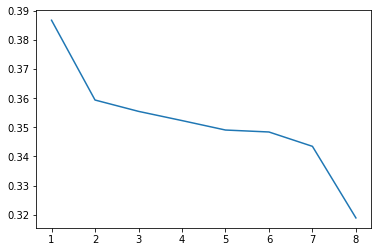

In [19]:
plt.plot(bucketid_list, train_recall_list)
plt.show()

[0.13560554918485002, 0.12408831510292043, 0.1283600516460909, 0.1380919345591692, 0.14762310422326727, 0.1573494594483979, 0.16556791763191264, 0.15618734845006801]


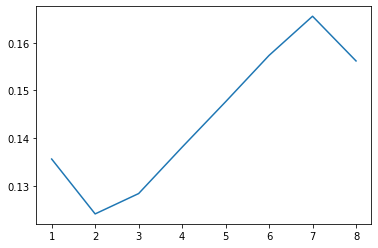

In [20]:
print(train_mrr_list)
plt.plot(bucketid_list, train_mrr_list)
plt.show()

In [137]:

print("--"*10+"eval test"+"--"*10)
mean_loss, mean_recall, mean_mrr = eval.eval(test_data_loader, "test")
msg = "eval loss: {:.4f}, recall: {:.4f}, mrr: {:.4f}".format(mean_loss, mean_recall, mean_mrr)
print(msg)

# test_item_freq_dict = dict(collections.Counter(test_data.m_y_action))
# print(len(test_item_freq_dict))
# itemfreq_list = list(test_item_freq_dict.values())
# print(len(itemfreq_list))
# for item in test_item_freq_dict:
# 	test_item_freq_dict[item] = test_item_freq_dict[item]/len(test_data.m_y_action)

--------------------eval test--------------------
shuffling
eval loss: 8.9094, recall: 0.1940, mrr: 0.0850


In [22]:
# test_freq_recall_dict, test_freq_mrr_dict = bias_eval(test_data_loader, train_item_freq_dict)
# test_bucket_recall_dict, test_bucket_mrr_dict = bias_eval(test_data_loader, train_itemid_bucketid_dict)

shuffling


In [18]:
def bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 5
    
    item_recall_dict = {}
    item_mrr_dict = {}
#     # ### load 
    # item_freq_dict = {}

    with torch.no_grad():
        total_test_num = []

        for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, \
            y_action_batch, y_action_idx_batch, _ in dataloader:
            
#             eval_flag = random.randint(1,101)
#             if eval_flag != 10:
#                 continue

#             batch_item_recall_dict = {}
#             batch_item_mrr_dict = {}

            x_short_action_batch = x_short_action_batch.to(device)
            mask_short_action_batch = mask_short_action_batch.to(device)
            y_action_batch = y_action_batch.to(device)

            # warm_start_mask = (y_action_idx_batch>=self.warm_start)

            output_batch = network(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

            sampled_logit_batch, sampled_target_batch = network.m_ss(output_batch, y_action_batch, \
                                                        None, None, None, None, None, None, "full")

            loss_batch = loss_function(sampled_logit_batch, sampled_target_batch)
            losses.append(loss_batch.item())

            _, preds = torch.topk(sampled_logit_batch, topk, -1)
            preds = preds.cpu()
            targets = sampled_target_batch.cpu()

            expand_targets = targets.view(-1, 1).expand_as(preds)
            hits = (preds == expand_targets)

            for i, hit in enumerate(hits):
                target_i = targets[i]
                itemid_i = target_i.item()
                
                rank = hit.nonzero()
                if itemid_i not in item_recall_dict:
                    item_recall_dict[itemid_i] = []
                    item_mrr_dict[itemid_i] = []
                    
                if len(rank) == 1:
                    item_recall_dict[itemid_i].append(1.0)
                    rank = rank[0]+1.0
                    rank = torch.reciprocal(rank.float())
                    item_mrr_dict[itemid_i].append(rank.item())
                else:
                    item_recall_dict[itemid_i].append(0.0)
                    item_mrr_dict[itemid_i].append(0.0)
                
#             for item in batch_item_recall_dict:
#                 batch_mean_recall = np.mean(batch_item_recall_dict[item])
#                 batch_mean_mrr = np.mean(batch_item_mrr_dict[item])
                
#                 if item not in item_recall_dict:
#                     item_recall_dict[item] = []
#                     item_mrr_dict[item] = []
#                 item_recall_dict[item].append(batch_mean_recall)
#                 item_mrr_dict[item].append(batch_mean_mrr)
                
            total_test_num.append(y_action_batch.view(-1).size(0))
    return item_recall_dict, item_mrr_dict
    

In [19]:
test_item_recall_dict, test_item_mrr_dict = bias_eval(test_data_loader, train_itemid_bucketid_dict)

shuffling


In [20]:
bucket_recall_dict = {}
bucket_mrr_dict = {}
for item in test_item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(test_item_recall_dict[item])
    
#     item_recall = item_recall[0]*1.0/item_recall[1]
    if bucketid not in bucket_recall_dict:
        bucket_recall_dict[bucketid] = []
        bucket_mrr_dict[bucketid] = []
    bucket_recall_dict[bucketid].append(item_recall)
    
    item_mrr = np.mean(test_item_mrr_dict[item])
#     item_mrr = item_mrr[0]*1.0/item_mrr[1]
    bucket_mrr_dict[bucketid].append(item_mrr)

for bucket in bucket_recall_dict:
    recall_list = bucket_recall_dict[bucket]
    mean_recall = np.mean(recall_list)
    bucket_recall_dict[bucket] = mean_recall

for bucket in bucket_mrr_dict:
    mrr_list = bucket_mrr_dict[bucket]
    mean_mrr = np.mean(mrr_list)
    bucket_mrr_dict[bucket] = mean_mrr  

In [21]:
print("recall")
for i in range(1, 9):
    print("%d:%.4f"%(i, bucket_recall_dict[i]), end=", ")
print()
print("mrr")
for i in range(1, 9):
    print("%d:%.4f"%(i, bucket_mrr_dict[i]), end=", ")
print()

recall
1:0.0890, 2:0.0948, 3:0.1045, 4:0.1086, 5:0.1124, 6:0.1248, 7:0.1391, 8:0.1674, 
mrr
1:0.0598, 2:0.0618, 3:0.0662, 4:0.0654, 5:0.0629, 6:0.0688, 7:0.0758, 8:0.0948, 


In [ ]:
recall
1:0.0753, 2:0.0787, 3:0.0852, 4:0.0860, 5:0.0842, 6:0.0939, 7:0.1046, 8:0.1260, 
mrr
1:0.0217, 2:0.0225, 3:0.0242, 4:0.0240, 5:0.0230, 6:0.0254, 7:0.0282, 8:0.0346, 
1


In [87]:
for i in range(1, 9):
    print("%d:%.4f"%(i, bucket_recall_dict[i]), end=", ")
print()

1:0.1401, 2:0.1812, 3:0.2027, 4:0.2285, 5:0.2352, 6:0.2339, 7:0.2609, 8:0.2820, 


In [88]:
for i in range(1, 9):
    print("%d:%.4f"%(i, bucket_mrr_dict[i]), end=", ")
print()

1:0.0657, 2:0.0705, 3:0.0712, 4:0.0796, 5:0.0792, 6:0.0789, 7:0.0903, 8:0.1013, 


In [23]:
print("recall")
test_recall_list = []
bucketid_list = []
for k in test_bucket_recall_dict:
    
    recall = test_bucket_recall_dict[k]
    print(k, "recall", recall)
    if recall[1] == 0:
        continue
    recall = recall[0]/recall[1]
    print("%.d:%.4f"%(k, recall), end=", ")
    
    bucketid_list.append(k)
    test_recall_list.append(recall)
print()

print("mrr")
test_mrr_list = []
for k in test_bucket_mrr_dict:
    mrr = test_bucket_mrr_dict[k]
    print(k, "mrr", mrr)
    if mrr[1] == 0:
        continue
    
    mrr = mrr[0]/mrr[1]
    print("%.d:%.4f"%(k, mrr), end=", ")
    test_mrr_list.append(mrr)
    
print()

recall
1 recall [16001.0, 61613.0]
1:0.2597, 2 recall [9403.0, 43640.0]
2:0.2155, 3 recall [9701.0, 48436.0]
3:0.2003, 4 recall [12094.0, 63801.0]
4:0.1896, 5 recall [8479.0, 45396.0]
5:0.1868, 6 recall [11607.0, 66284.0]
6:0.1751, 7 recall [7977.0, 48144.0]
7:0.1657, 8 recall [8281.0, 53278.0]
8:0.1554, 
mrr
1 mrr [5708.227902315557, 61613.0]
1:0.0926, 2 mrr [3427.2591065838933, 43640.0]
2:0.0785, 3 mrr [3799.715749938041, 48436.0]
3:0.0784, 4 mrr [5217.620945863426, 63801.0]
4:0.0818, 5 mrr [3908.5877353213727, 45396.0]
5:0.0861, 6 mrr [5794.360123116523, 66284.0]
6:0.0874, 7 mrr [4119.804924279451, 48144.0]
7:0.0856, 8 mrr [4617.470670457929, 53278.0]
8:0.0867, 


In [24]:
# test_recall_list = [0.1316, 0.1243, 0.1281, 0.1363, 0.1435, 0.1570, 0.1605, 0.2118]
# test_mrr_list = [0.0789, 0.0734, 0.0733, 0.0762, 0.0792, 0.0850, 0.0806, 0.0892]
# freq_list = [i for i in range(8)]

In [29]:
print("recall")
for i in test_recall_list:
    print("%.4f"%i, end=", ")
print()
print("mrr")
for i in test_mrr_list:
    print("%.4f"%i, end=", ")
print()
# print(test_mrr_list)

recall
0.2597, 0.2155, 0.2003, 0.1896, 0.1868, 0.1751, 0.1657, 0.1554, 
mrr
0.0926, 0.0785, 0.0784, 0.0818, 0.0861, 0.0874, 0.0856, 0.0867, 


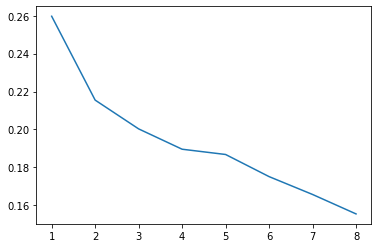

In [25]:
plt.plot(bucketid_list, test_recall_list)
plt.show()

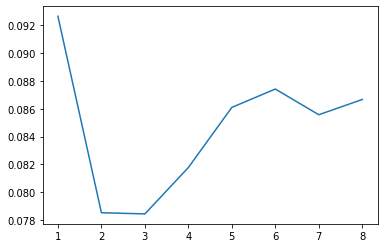

In [26]:
plt.plot(bucketid_list, test_mrr_list)
plt.show()

### re-rank the results by debiasing method

#### get the score of the prediction

In [16]:
input_size = data_obj.items()
print("item num in model", input_size)

item num 68008
item num in model 68008


In [26]:
len(train_item_freq_dict)

68006

In [27]:
item_list = list(train_item_freq_dict.keys())
print(max(item_list), min(item_list))

68007 1


In [28]:
for i in range(input_size):
    if i not in item_list:
        print(i)

0
67420


In [36]:
train_item_freq_list = [train_item_freq_dict[i] if i in train_item_freq_dict else 0.0 for i in range(input_size)]
item_pop = torch.from_numpy(np.array(train_item_freq_list)).to(device)
item_pop = item_pop+1e-20
print(item_pop.size(), item_pop.device)

torch.Size([68008]) cuda:0


In [45]:
beta = 0.3
def compensation(logits):
    logits = logits*beta+(1-beta)
    
#     print("logits", logits, torch.max(logits, dim=-1))
    com_logits = logits/item_pop.unsqueeze(0)
#     print("com_logits 1", com_logits, torch.max(com_logits, dim=-1))
    return com_logits

In [46]:
alpha = 0.8
def compensated_score(logits):
    com_logits = compensation(logits)
    
    com_logits[:, 0] = 0
    com_logits[:, 67420] = 0
        
    n_u = torch.norm(logits, dim=-1, keepdim=True)
    m_u = torch.norm(com_logits, dim=-1, keepdim=True)
    
#     print("n_u", n_u.size())
#     print("m_u", m_u.size())
    tmp = alpha*com_logits*n_u/m_u
    final_score = logits+tmp
#     print("tmp", tmp)
#     print("n_u", n_u)
#     print("m_u", m_u)
#     print("logits", logits)
    
    return final_score

In [47]:
def compensated_bias_eval(eval_data, itemid_bucketid_dict):
    network.eval()

    losses = []
    recalls = []
    mrrs = []
    weights = []

    dataloader = eval_data
    topk = 5
    
    item_recall_dict = {}
    item_mrr_dict = {}
#     # ### load 
    # item_freq_dict = {}

    with torch.no_grad():
        total_test_num = []
        
        batch_index = 0
        for x_short_action_batch, mask_short_action_batch, \
            pad_x_short_actionNum_batch, y_action_batch, y_action_idx_batch, _ in dataloader:

            x_short_action_batch = x_short_action_batch.to(device)
            mask_short_action_batch = mask_short_action_batch.to(device)
            y_action_batch = y_action_batch.to(device)

            # warm_start_mask = (y_action_idx_batch>=self.warm_start)
        
#             batch_index += 1
#             if batch_index > 1:
#                 break
        
            output_batch = network(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

            sampled_logit_batch, sampled_target_batch = network.m_ss(output_batch, y_action_batch, \
                                                        None, None, None, None, None, None, "full")
            
#             print("sample logit size", sampled_logit_batch.size())
            compensated_logits = compensated_score(sampled_logit_batch)
            
            _, preds = torch.topk(compensated_logits, topk, -1)
            preds = preds.cpu()
            targets = sampled_target_batch.cpu()

            expand_targets = targets.view(-1, 1).expand_as(preds)
            hits = (preds == expand_targets)

            for i, hit in enumerate(hits):
                target_i = targets[i]
                itemid_i = target_i.item()
                
                rank = hit.nonzero()
                if itemid_i not in item_recall_dict:
                    item_recall_dict[itemid_i] = []
                    item_mrr_dict[itemid_i] = []
                    
                if len(rank) == 1:
                    item_recall_dict[itemid_i].append(1.0)
                    rank = rank[0]+1.0
                    rank = torch.reciprocal(rank.float())
                    item_mrr_dict[itemid_i].append(rank.item())
                else:
                    item_recall_dict[itemid_i].append(0.0)
                    item_mrr_dict[itemid_i].append(0.0)
                
#             for item in batch_item_recall_dict:
#                 batch_mean_recall = np.mean(batch_item_recall_dict[item])
#                 batch_mean_mrr = np.mean(batch_item_mrr_dict[item])
                
#                 if item not in item_recall_dict:
#                     item_recall_dict[item] = []
#                     item_mrr_dict[item] = []
#                 item_recall_dict[item].append(batch_mean_recall)
#                 item_mrr_dict[item].append(batch_mean_mrr)
                
            total_test_num.append(y_action_batch.view(-1).size(0))
    return item_recall_dict, item_mrr_dict
    

In [48]:
compensated_test_item_recall_dict, compensated_test_item_mrr_dict = compensated_bias_eval(test_data_loader, train_itemid_bucketid_dict)

shuffling


In [49]:
compensated_bucket_recall_dict = {}
compensated_bucket_mrr_dict = {}
for item in compensated_test_item_recall_dict:
    bucketid = train_itemid_bucketid_dict[item]
    item_recall = np.mean(compensated_test_item_recall_dict[item])
    
    if bucketid not in compensated_bucket_recall_dict:
        compensated_bucket_recall_dict[bucketid] = []
        compensated_bucket_mrr_dict[bucketid] = []
    compensated_bucket_recall_dict[bucketid].append(item_recall)
    
    item_mrr = np.mean(compensated_test_item_mrr_dict[item])
    compensated_bucket_mrr_dict[bucketid].append(item_mrr)

for bucket in compensated_bucket_recall_dict:
    recall_list = compensated_bucket_recall_dict[bucket]
    mean_recall = np.mean(recall_list)
    compensated_bucket_recall_dict[bucket] = mean_recall

for bucket in compensated_bucket_mrr_dict:
    mrr_list = compensated_bucket_mrr_dict[bucket]
    mean_mrr = np.mean(mrr_list)
    compensated_bucket_mrr_dict[bucket] = mean_mrr  

In [50]:
print("recall")
for i in range(1, 9):
    print("%d:%.4f"%(i, compensated_bucket_recall_dict[i]), end=", ")
print()
print("mrr")
for i in range(1, 9):
    print("%d:%.4f"%(i, compensated_bucket_mrr_dict[i]), end=", ")
print()

recall
1:0.1144, 2:0.0796, 3:0.0515, 4:0.0239, 5:0.0063, 6:0.0031, 7:0.0013, 8:0.0018, 
mrr
1:0.0722, 2:0.0463, 3:0.0276, 4:0.0115, 5:0.0027, 6:0.0012, 7:0.0004, 8:0.0006, 


In [66]:
print("recall")
for i in range(1, 9):
    print("%d:%.4f"%(i, compensated_bucket_recall_dict[i]), end=", ")
print()
print("mrr")
for i in range(1, 9):
    print("%d:%.4f"%(i, compensated_bucket_mrr_dict[i]), end=", ")
print()

recall
1:0.0753, 2:0.0787, 3:0.0852, 4:0.0860, 5:0.0842, 6:0.0939, 7:0.1046, 8:0.1260, 
mrr
1:0.0217, 2:0.0225, 3:0.0242, 4:0.0240, 5:0.0230, 6:0.0254, 7:0.0282, 8:0.0346, 


#### get new recommendations

In [2]:
import torch

In [3]:
a = torch.randn((2, 4))

In [5]:
b = torch.tensor([2, 3])

In [6]:
print("a", a)
print("b", b)

a tensor([[-0.8688,  0.7647,  0.0848,  0.4191],
        [-0.8668, -0.8401,  0.7437, -0.2082]])
b tensor([2, 3])


In [9]:
a[torch.arange(2), b]

tensor([ 0.0848, -0.2082])

In [11]:
a.gather(1, b.unsqueeze(-1))

tensor([[ 0.0848],
        [-0.2082]])